In [218]:
import librosa
import os
import numpy as np
import mir_eval
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
#from os import walk
import pickle
import copy
import timeit
import inspect
import sys
import numpy
import random
from collections import OrderedDict

import theano
import theano.tensor as T
from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

from sklearn.preprocessing import normalize
from mir_eval.separation import bss_eval_sources
sys.setrecursionlimit(15000)

%matplotlib inline
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

In [2]:
def tdataset(point):#load data
    for path, dirs, files in os.walk('Wavfile'):
        for name in files:
            y, sr = librosa.load('Wavfile/'+ name, sr=16000, mono=False)
            D = librosa.stft(y[0] + y[1], n_fft = 1024, hop_length = 512)[:,:point]
            D1 = librosa.stft(y[0], n_fft = 1024, hop_length = 512)[:,:point]
            D2 = librosa.stft(y[1], n_fft = 1024, hop_length = 512)[:,:point]
            if D.shape[1] < point:
                tmp = np.zeros((513,point - D.shape[1]),dtype = float)
                D = np.column_stack((D, tmp))
            if D1.shape[1] < point:
                tmp = np.zeros((513,point - D1.shape[1]),dtype = float)
                D1 = np.column_stack((D1, tmp))
            if D2.shape[1] < point:
                tmp = np.zeros((513,point - D2.shape[1]),dtype = float)
                D2 = np.column_stack((D2, tmp))
            magnitude, phase = librosa.magphase(D)
            magnitude = magnitude.T.flatten()
            phase = phase.T.flatten()
            magnitude1, phase1 = librosa.magphase(D1)
            magnitude1 = magnitude1.T.flatten()
            phase1 = phase1.T.flatten()
            magnitude2, phase2 = librosa.magphase(D2)
            magnitude2 = magnitude2.T.flatten()
            phase2 = phase2.T.flatten()
            if name[:7] == 'Aaliyah':
                if name == 'Aaliyah_0012.wav' or name == 'Aaliyah_0012.wav':              
                    try:
                        dva = np.vstack((dva,magnitude))
                        pva = np.vstack((ptr,phase))
                    except UnboundLocalError:
                        dva = magnitude
                        pva = phase
                    try:
                        d1va = np.vstack((d1va,magnitude1))
                        p1va = np.vstack((p1va,phase1))
                    except UnboundLocalError:
                        d1va = magnitude1
                        p1va = phase1
                    try:
                        d2va = np.vstack((d2va,magnitude2))
                        p2va = np.vstack((p2va,phase2))
                    except UnboundLocalError:
                        d2va = magnitude2
                        p2va = phase2
                else:
                    try:
                        dtr = np.vstack((dtr,magnitude))
                        ptr = np.vstack((ptr,phase))
                    except UnboundLocalError:
                        dtr = magnitude
                        ptr = phase
                    try:
                        d1tr = np.vstack((d1tr,magnitude1))
                        p1tr = np.vstack((p1tr,phase1))
                    except UnboundLocalError:
                        d1tr = magnitude1
                        p1tr = phase1
                    try:
                        d2tr = np.vstack((d2tr,magnitude2))
                        p2tr = np.vstack((p2tr,phase2))
                    except UnboundLocalError:
                        d2tr = magnitude2
                        p2tr = phase2

            else:
                try:
                    dte = np.vstack((dte,magnitude))
                    pte = np.vstack((pte,phase))
                except UnboundLocalError:
                    dte = magnitude
                    pte = phase
                try:
                    d1te = np.vstack((d1te,magnitude1))
                    p1te = np.vstack((p1te,phase1))
                except UnboundLocalError:
                    d1te = magnitude1
                    p1te = phase1
                try:
                    d2te = np.vstack((d2te,magnitude2))
                    p2te = np.vstack((p2te,phase2))
                except UnboundLocalError:
                    d2te = magnitude2
                    p2te = phase2
    trdata = [dtr,d1tr,d2tr]
    tedata = [dte,d1te,d2te]
    trphase = [ptr, p1tr,p2tr]
    tephase = [pte, p1te,p2te]
    vadata = [dva,d1va,d2va]
    vaphase = [pva,p1va,p2va]
    return trdata ,tedata, trphase, tephase, vadata, vaphase

In [3]:
trdata ,tedata, trphase, tephase, vadata, vaphase = tdataset(100)

In [4]:
#save data if you want
'''
pickle.dump( trdata, open( "trdata.p", "wb" ) )
pickle.dump( tedata, open( "tedata.p", "wb" ) )
pickle.dump( trphase, open( "trphase.p", "wb" ) )
pickle.dump( tephase, open( "tephase.p", "wb" ) )
pickle.dump( vadata, open( "vadata.p", "wb" ) )
pickle.dump( vaphase, open( "vaphase.p", "wb" ) )
'''

'\npickle.dump( trdata, open( "trdata.p", "wb" ) )\npickle.dump( tedata, open( "tedata.p", "wb" ) )\npickle.dump( trphase, open( "trphase.p", "wb" ) )\npickle.dump( tephase, open( "tephase.p", "wb" ) )\npickle.dump( vadata, open( "vadata.p", "wb" ) )\npickle.dump( vaphase, open( "vaphase.p", "wb" ) )\n'

In [ ]:
class RNNSLU3(object):
    """ Elman Neural Net Model Class
    """
    def __init__(self, input, nh):
        """Initialize the parameters for the RNNSLU

        :type nh: int
        :param nh: dimension of the first hidden layer

        :type cs: int
        :param cs: input lenth

        """
        # parameters of the model
        self.h1 = theano.shared(name='h1', value=numpy.zeros(nh,dtype=theano.config.floatX))
        self.h2 = theano.shared(name='h2', value=numpy.zeros(nh,dtype=theano.config.floatX))
        self.h3 = theano.shared(name='h3', value=numpy.zeros(nh,dtype=theano.config.floatX))

        self.wx1 = theano.shared(name='wx1', value=0.2 * numpy.random.uniform(-1.0, 1.0, (513, nh)).astype(theano.config.floatX))
        self.wx2 = theano.shared(name='wx2', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))
        self.wx3 = theano.shared(name='wx3', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))

        self.wh1 = theano.shared(name='wh1', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))
        self.wh2 = theano.shared(name='wh2', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))
        self.wh3 = theano.shared(name='wh3', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))


        # bundle
        self.params = [self.h1, self.h2, self.h3, self.wx1, self.wx2, self.wx3, self.wh1, self.wh2, self.wh3]

        # as many columns as context window size
        # as many lines as words in the sequence
        x = (input.reshape((100,513)))


        def recurrence(x_t, h1_tm1,h2_tm1,h3_tm1):
            h1_t = T.nnet.relu(T.dot(x_t, self.wx1) + T.dot(h1_tm1, self.wh1))
            h2_t = T.nnet.relu(T.dot(h1_t,self.wx2) + T.dot(h2_tm1, self.wh2))
            h3_t = T.nnet.relu(T.dot(h2_t,self.wx3) + T.dot(h3_tm1, self.wh3))
            return [h1_t, h2_t, h3_t]

        [h1,h2,h3], _ = theano.scan(fn=recurrence,
                               sequences=x,
                               outputs_info=[self.h1, self.h2, self.h3],
                               n_steps=x.shape[0])
        self.output = h3


def shared_dataset(x):
    shared_x = theano.shared(numpy.asarray(x,
                                           dtype=theano.config.floatX),
                             borrow=True)
    return shared_x
def test_DRNN(trdata ,tedata, vadata, learning_rate=0.1, n_epochs=20, batch_size=1, point = 100):
    """ Demonstrates lenet on MNIST dataset

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: path to the dataset used for training /testing (MNIST here)

    :type nkerns: list of ints
    :param nkerns: number of kernels on each layer
    """

    rng = numpy.random.RandomState(23455)

    train_set_x = shared_dataset(trdata[0])
    test_set_x = shared_dataset(tedata[0])
    train_set_z = shared_dataset(trdata[0])
    test_set_z = shared_dataset(tedata[0])
    train_set_y1 = shared_dataset(trdata[1])
    test_set_y1 = shared_dataset(tedata[1])
    train_set_y2 = shared_dataset(trdata[2])
    test_set_y2 = shared_dataset(tedata[2])
    valid_set_x = shared_dataset(vadata[0])
    valid_set_z = shared_dataset(vadata[0])
    valid_set_y1 = shared_dataset(vadata[1])
    valid_set_y2 = shared_dataset(vadata[2])

    n_train_batches = len(trdata[0])
    n_test_batches = len(tedata[0])
    n_valid_batches = len(vadata[0])
    # compute number of minibatches for training, validation and testing
#    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
#    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
#    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
#    n_train_batches //= batch_size
#    n_valid_batches //= batch_size
#    n_test_batches //= batch_size


    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    # start-snippet-1
    x = T.vector('x')   # the data is presented as rasterized images
    y1 = T.vector('y1')  # the labels are presented as 1D vector of
    y2 = T.vector('y2')
    z = T.vector('z')                    # [int] labels

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # Reshape matrix of rasterized images of shape (batch_size, 32 * 32)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    # (32, 32) is the size of CIFAR-10 images.
    layer0_input = x

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (32-3+1 , 32-3+1) = (30, 30)
    # maxpooling reduces this further to (30/2, 30/2) = (15, 15)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 15, 15)
    # filter_shape: (number of filters, num input feature maps, filter height, filter width)
    layer0 = RNNSLU3(
        input=layer0_input,
        nh = 150
    )
    w = theano.shared(name='w', value=numpy.random.uniform(-1.0, 1.0, (150, 1026)).astype(theano.config.floatX))
    b = theano.shared(name='b', value=numpy.zeros((1026,), dtype=theano.config.floatX))



    tmp = T.nnet.relu(T.dot(layer0.output, w) + b)

    tmp1 = tmp[:,:513]
    tmp2 = tmp[:,513:]
    #out1 = abs(tmp1)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    #out2 = abs(tmp2)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    #cost = T.mean((out1-y1.reshape((point,513)))**2+(out2-y2.reshape((point,513)))**2)
    out1 = abs(tmp1)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    out2 = abs(tmp2)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    cost = T.mean((out1-y1.reshape((point,513)))**2+(out2-y2.reshape((point,513)))**2)
    #(sdr1, sir1, sar1,perm1) = mir_eval.separation.bss_eval_sources(out1.flatten(),z)
    #(sdr2, sir2, sar2,perm2) = mir_eval.separation.bss_eval_sources(y1.flatten(),z)
    #error =  sdr1-sdr2
    error = cost
    # create a function to compute the mistakes that are made by the model

    test_model = theano.function(
        [index],
        error,
        givens={
            x: test_set_x[index],
            y1: test_set_y1[index],
            y2: test_set_y2[index],
            z: test_set_z[index]
        }
    )

    validate_model = theano.function(
        [index],
        error,
        givens={
            x: valid_set_x[index],
            y1: valid_set_y1[index],
            y2: valid_set_y2[index],
            z: valid_set_z[index]
        }
    )

    # create a list of all model parameters to be fit by gradient descent
    params = [w, b] + layer0.params
    '''
    # create a list of gradients for all model parameters
    grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]
    '''
    updates = Adam(cost, params, lr=0.0002, b1=0.1, b2=0.001, e=1e-8)

    train_model = theano.function(
        [index],
        cost,
        updates = updates,
        givens={
            x: train_set_x[index],
            y1: train_set_y1[index],
            y2: train_set_y2[index],
            z: train_set_z[index]
        }
    )

    # end-snippet-1

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')
    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 50  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            iter = (epoch - 1) * n_train_batches + minibatch_index

            if iter % 100 == 0:
                print('training @ iter = ', iter)
            cost_ij = train_model(minibatch_index)
            if (iter + 1) % validation_frequency == 0:

                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    #improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [
                        test_model(i)
                        for i in range(n_test_batches)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f ') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score))

            if patience <= iter:
                done_looping = True
                break
    out_model = theano.function(
        [index],
        [out1,out2],
        givens={
            x: valid_set_x[index],
            z: valid_set_z[index]
        }
    )
    out_wav=[]
    for i in range(n_valid_batches):
        out_wav.append(out_model(i))

    end_time = timeit.default_timer()
    print('Optimization complete.')
    print('Best validation score of %f  obtained at iteration %i, '
          'with test performance %f ' %
          (best_validation_loss, best_iter + 1, test_score ))
    print(('The code for file ' +
           os.path.split(__file__)[1] +
           ' ran for %.2fm' % ((end_time - start_time) / 60.)))
    return out_wav

def Adam(cost, params, lr=0.0002, b1=0.1, b2=0.001, e=1e-8):
    updates = []
    grads = T.grad(cost, params)
    i = theano.shared(numpy.float32(0))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates

In [7]:
#train drnn!
out=test_DRNN(trdata ,tedata, vadata, learning_rate=0.1, n_epochs=2000, batch_size=1, point = 100)

... building the model
... training
('training @ iter = ', 0)
('training @ iter = ', 100)
epoch 1, minibatch 171/171, validation error 6.861794
     epoch 1, minibatch 171/171, test error of best model 8.102632 
('training @ iter = ', 200)
('training @ iter = ', 300)
epoch 2, minibatch 171/171, validation error 6.691068
     epoch 2, minibatch 171/171, test error of best model 7.755342 
('training @ iter = ', 400)
('training @ iter = ', 500)
epoch 3, minibatch 171/171, validation error 6.688918
     epoch 3, minibatch 171/171, test error of best model 7.633197 
('training @ iter = ', 600)
epoch 4, minibatch 171/171, validation error 6.641753
     epoch 4, minibatch 171/171, test error of best model 7.573475 
('training @ iter = ', 700)
('training @ iter = ', 800)
epoch 5, minibatch 171/171, validation error 6.685473
('training @ iter = ', 900)
('training @ iter = ', 1000)
epoch 6, minibatch 171/171, validation error 6.584797
     epoch 6, minibatch 171/171, test error of best model 7.5

In [301]:
#transfer data back to wav
def istft_mp(mag, phase):
    y_hat = librosa.istft(mag*phase, hop_length = 512)
    return y_hat

# for each song: return sdr, sir, sar for a single song
def evaluate(ori_sing, out_sing, mix):
    sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources( ori_sing, out_sing )
    sdr1, sir1, sar1, perm1 = mir_eval.separation.bss_eval_sources( ori_sing, mix )
    nsdr = sdr - sdr1
    return nsdr, sir, sar

# for all song's evaluation vectors: weighted index
'''
def g_eval(v_nsdr, v_sir, v_sar, v_length):
    sum_length = sum(v_lengeth)
    w_length = v_length/sum_length
    gnsdr = T.dot(v_nsdr, w_length)
    gsir = T.dot(v_sir, w_length)
    gsar = T.dot(v_sar, w_length)
    return gnsdr, gsir, gsar
'''
def g_eval(v_nsdr, v_sir, v_sar):
    gnsdr = np.mean(v_nsdr)
    gsir = np.mean(v_sir)
    gsar = np.mean(v_sar)
    return gnsdr, gsir, gsar

# output wav files
def prod_wav(out_sing,mix, ori_right, i):
    import os
    librosa.output.write_wav(os.path.join(os.getcwd() + '/out/' + '%i'%i + '_gt_mix.wav'),sr=16000,y=mix)
    librosa.output.write_wav(os.path.join(os.getcwd() + '/out/' + '%i'%i + '_pred_right.wav'),sr=16000,y=out_sing)
    librosa.output.write_wav(os.path.join(os.getcwd() + '/out/' + '%i'%i + '_ori_right.wav'),sr=16000,y=ori_right)

In [302]:
outphase=tephase[0][0].reshape(100,513).T
lphase=tephase[1][0].reshape(100,513).T
rphase=tephase[2][0].reshape(100,513).T

In [303]:
n_nsdr=[]
n_sir=[]
n_sar=[]
for i in range(len(out)):
    mag=out[i][0]+out[i][1]
    y_hat=istft_mp(mag.T,outphase)
    y_left=istft_mp(tedata[1][i].reshape(100,513).T,lphase)
    y_right=istft_mp(tedata[2][i].reshape(100,513).T,rphase)
    nsdr, sir, sar=evaluate(tedata[0][i],out[i][0].flatten(),tedata[2][i])
    n_nsdr.append(nsdr)
    n_sir.append(sir)
    n_sar.append(sar)
    prod_wav(istft_mp(out[i][1].T,rphase),y_hat,y_right,i)
gnsdr, gsir, gsar=g_eval(n_nsdr, n_sir, n_sar)  

In [299]:
gnsdr, gsir, gsar

(6.1377355511498335, inf, 5.7434316352029686)

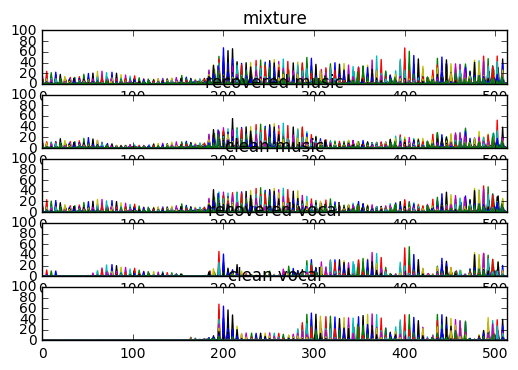

In [210]:
plt.subplot(5,1,1)
plt.plot(tedata[0][0].reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('mixture')
plt.subplot(5,1,2)
plt.plot(out[0][0].flatten().reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('recovered music')
plt.subplot(5,1,3)
plt.plot(tedata[1][0].reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('clean music')
plt.subplot(5,1,4)
plt.plot(out[0][1].flatten().reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('recovered vocal')
plt.subplot(5,1,5)
plt.plot(tedata[2][0].reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('clean vocal')
plt.show()

In [ ]:
class RNNSLU3(object):
    """ Elman Neural Net Model Class
    """
    def __init__(self, input, nh):
        """Initialize the parameters for the RNNSLU

        :type nh: int
        :param nh: dimension of the first hidden layer

        :type cs: int
        :param cs: input lenth

        """
        # parameters of the model
        self.h1 = theano.shared(name='h1', value=numpy.zeros(nh,dtype=theano.config.floatX))
        self.h2 = theano.shared(name='h2', value=numpy.zeros(nh,dtype=theano.config.floatX))
        self.h3 = theano.shared(name='h3', value=numpy.zeros(nh,dtype=theano.config.floatX))

        self.wx1 = theano.shared(name='wx1', value=0.2 * numpy.random.uniform(-1.0, 1.0, (513, nh)).astype(theano.config.floatX))
        self.wx2 = theano.shared(name='wx2', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))
        self.wx3 = theano.shared(name='wx3', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))

        self.wh1 = theano.shared(name='wh1', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))
        self.wh2 = theano.shared(name='wh2', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))
        self.wh3 = theano.shared(name='wh3', value=0.2 * numpy.random.uniform(-1.0, 1.0, (nh, nh)).astype(theano.config.floatX))


        # bundle
        self.params = [self.h1, self.h2, self.h3, self.wx1, self.wx2, self.wx3, self.wh1, self.wh2, self.wh3]

        # as many columns as context window size
        # as many lines as words in the sequence
        x = (input.reshape((100,513)))


        def recurrence(x_t, h1_tm1,h2_tm1,h3_tm1):
            h1_t = T.nnet.relu(T.dot(x_t, self.wx1) + T.dot(h1_tm1, self.wh1))
            h2_t = T.nnet.relu(T.dot(h1_t,self.wx2) + T.dot(h2_tm1, self.wh2))
            h3_t = T.nnet.relu(T.dot(h2_t,self.wx3) + T.dot(h3_tm1, self.wh3))
            return [h1_t, h2_t, h3_t]

        [h1,h2,h3], _ = theano.scan(fn=recurrence,
                               sequences=x,
                               outputs_info=[self.h1, self.h2, self.h3],
                               n_steps=x.shape[0])
        self.output = h3

def IS(x,y):
    return T.sum((-T.log(abs(x)/(abs(y)+10**(-8)))+(abs(x)/(abs(y)+10**(-8)))-1))

def shared_dataset(x):
    shared_x = theano.shared(numpy.asarray(x,
                                           dtype=theano.config.floatX),
                             borrow=True)
    return shared_x
def test_DRNN(trdata ,tedata, vadata, learning_rate=0.1, n_epochs=20, batch_size=1, point = 100, isd = False):
    """ Demonstrates lenet on MNIST dataset

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: path to the dataset used for training /testing (MNIST here)

    :type nkerns: list of ints
    :param nkerns: number of kernels on each layer
    """

    rng = numpy.random.RandomState(23455)

    train_set_x = shared_dataset(trdata[0])
    test_set_x = shared_dataset(tedata[0])
    train_set_z = shared_dataset(trdata[0])
    test_set_z = shared_dataset(tedata[0])
    train_set_y1 = shared_dataset(trdata[1])
    test_set_y1 = shared_dataset(tedata[1])
    train_set_y2 = shared_dataset(trdata[2])
    test_set_y2 = shared_dataset(tedata[2])
    valid_set_x = shared_dataset(vadata[0])
    valid_set_z = shared_dataset(vadata[0])
    valid_set_y1 = shared_dataset(vadata[1])
    valid_set_y2 = shared_dataset(vadata[2])

    n_train_batches = len(trdata[0])
    n_test_batches = len(tedata[0])
    n_valid_batches = len(vadata[0])
    # compute number of minibatches for training, validation and testing
#    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
#    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
#    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
#    n_train_batches //= batch_size
#    n_valid_batches //= batch_size
#    n_test_batches //= batch_size


    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    # start-snippet-1
    x = T.vector('x')   # the data is presented as rasterized images
    y1 = T.vector('y1')  # the labels are presented as 1D vector of
    y2 = T.vector('y2')
    z = T.vector('z')                    # [int] labels

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # Reshape matrix of rasterized images of shape (batch_size, 32 * 32)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    # (32, 32) is the size of CIFAR-10 images.
    layer0_input = x

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (32-3+1 , 32-3+1) = (30, 30)
    # maxpooling reduces this further to (30/2, 30/2) = (15, 15)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 15, 15)
    # filter_shape: (number of filters, num input feature maps, filter height, filter width)
    layer0 = RNNSLU3(
        input=layer0_input,
        nh = 150
    )
    w = theano.shared(name='w', value=0.2 * numpy.random.uniform(-1.0, 1.0, (150, 1026)).astype(theano.config.floatX))
    b = theano.shared(name='b', value=numpy.zeros((1026,), dtype=theano.config.floatX))



    tmp = T.nnet.relu(T.dot(layer0.output, w) + b)

    tmp1 = tmp[:,:513]
    tmp2 = tmp[:,513:]
    #out1 = abs(tmp1)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    #out2 = abs(tmp2)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    #cost = T.mean((out1-y1.reshape((point,513)))**2+(out2-y2.reshape((point,513)))**2)
    out1 = abs(tmp1)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))
    out2 = abs(tmp2)/(abs(tmp1) + abs(tmp2)+10**(-8))*z.reshape((point,513))

    if isd == True:
        cost = IS(out1, y1.reshape((point,513))) + IS(out2,y2.reshape((point,513))) - IS(out2, y1.reshape((point,513)))/2 - IS(out1, y2.reshape((point,513)))/2

    else:
        cost = T.mean((out1-y1.reshape((point,513)))**2+(out2-y2.reshape((point,513)))**2)
    #(sdr1, sir1, sar1,perm1) = mir_eval.separation.bss_eval_sources(out1.flatten(),z)
    #(sdr2, sir2, sar2,perm2) = mir_eval.separation.bss_eval_sources(y1.flatten(),z)
    #error =  sdr1-sdr2
    error = cost
    # create a function to compute the mistakes that are made by the model

    test_model = theano.function(
        [index],
        error,
        givens={
            x: test_set_x[index],
            y1: test_set_y1[index],
            y2: test_set_y2[index],
            z: test_set_z[index]
        }
    )

    validate_model = theano.function(
        [index],
        error,
        givens={
            x: valid_set_x[index],
            y1: valid_set_y1[index],
            y2: valid_set_y2[index],
            z: valid_set_z[index]
        }
    )

    # create a list of all model parameters to be fit by gradient descent
    params = [w, b] + layer0.params
    '''
    # create a list of gradients for all model parameters
    grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]
    '''
    updates = Adam(cost, params, lr=0.0002, b1=0.1, b2=0.001, e=1e-8)

    train_model = theano.function(
        [index],
        cost,
        updates = updates,
        givens={
            x: train_set_x[index],
            y1: train_set_y1[index],
            y2: train_set_y2[index],
            z: train_set_z[index]
        }
    )

    # end-snippet-1

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')
    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 50  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            iter = (epoch - 1) * n_train_batches + minibatch_index

            if iter % 100 == 0:
                print('training @ iter = ', iter)
            cost_ij = train_model(minibatch_index)
            if (iter + 1) % validation_frequency == 0:

                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    #improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [
                        test_model(i)
                        for i in range(n_test_batches)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f ') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score))

            if patience <= iter:
                done_looping = True
                break
    out_model = theano.function(
        [index],
        [out1,out2],
        givens={
            x: test_set_x[index],
            z: test_set_z[index]
        }
    )
    out_wav = out_model(0),

    end_time = timeit.default_timer()
    print('Optimization complete.')
    print('Best validation score of %f  obtained at iteration %i, '
          'with test performance %f ' %
          (best_validation_loss, best_iter + 1, test_score ))
    print(('The code for file ' +
           os.path.split(__file__)[1] +
           ' ran for %.2fm' % ((end_time - start_time) / 60.)))
    return out_wav

def Adam(cost, params, lr=0.0002, b1=0.1, b2=0.001, e=1e-8):
    updates = []
    grads = T.grad(cost, params)
    i = theano.shared(numpy.float32(0))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates

In [247]:
#train with IS distance
out2=test_DRNN(trdata ,tedata, vadata, learning_rate=0.1, n_epochs=500, batch_size=1, point = 100)

... building the model
... training
('training @ iter = ', 0)
('training @ iter = ', 100)
epoch 1, minibatch 171/171, validation error 5.743012
     epoch 1, minibatch 171/171, test error of best model 6.644637 
('training @ iter = ', 200)
('training @ iter = ', 300)
epoch 2, minibatch 171/171, validation error 5.803921
('training @ iter = ', 400)
('training @ iter = ', 500)
epoch 3, minibatch 171/171, validation error 5.866738
('training @ iter = ', 600)
epoch 4, minibatch 171/171, validation error 5.373933
     epoch 4, minibatch 171/171, test error of best model 6.051428 
('training @ iter = ', 700)
('training @ iter = ', 800)
epoch 5, minibatch 171/171, validation error 5.416467
('training @ iter = ', 900)
('training @ iter = ', 1000)
epoch 6, minibatch 171/171, validation error 5.569803
('training @ iter = ', 1100)
epoch 7, minibatch 171/171, validation error 5.519544
('training @ iter = ', 1200)
('training @ iter = ', 1300)
epoch 8, minibatch 171/171, validation error 5.627355
('

In [306]:
n_nsdr2=[]
n_sir2=[]
n_sar2=[]
for i in range(len(out2)):
    mag=out2[i][0]+out2[i][1]
    y_hat=istft_mp(mag.T,outphase)
    y_left=istft_mp(tedata[1][i].reshape(100,513).T,lphase)
    y_right=istft_mp(tedata[2][i].reshape(100,513).T,rphase)
    nsdr, sir, sar=evaluate(tedata[2][i],out2[i][1].T.flatten(),tedata[0][i])
    n_nsdr2.append(nsdr)
    n_sir2.append(sir)
    n_sar2.append(sar)
    prod_wav(istft_mp(out2[i][1].T,rphase),y_hat,y_right,i+1)
gnsdr2, gsir2, gsar2=g_eval(n_nsdr2, n_sir2, n_sar2)  

In [284]:
gnsdr2, gsir2, gsar2

(6.0834858133478411, inf, 5.6891818974009762)

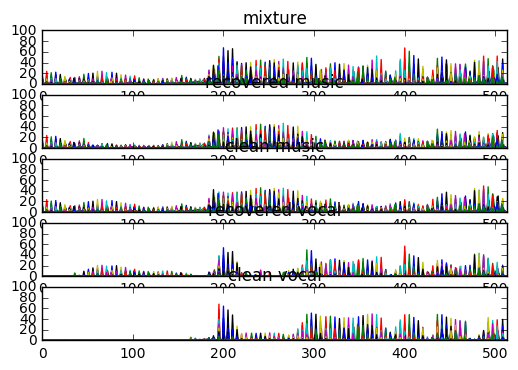

In [307]:
plt.subplot(5,1,1)
plt.plot(tedata[0][0].reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('mixture')
plt.subplot(5,1,2)
plt.plot(out2[0][0].flatten().reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('recovered music')
plt.subplot(5,1,3)
plt.plot(tedata[1][0].reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('clean music')
plt.subplot(5,1,4)
plt.plot(out2[0][1].flatten().reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('recovered vocal')
plt.subplot(5,1,5)
plt.plot(tedata[2][0].reshape(513,100))
plt.axis([0, 513, 0, 100])
plt.title('clean vocal')
plt.show()